In [28]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline
import os

In [35]:
train_path = os.path.join(os.getcwd(),'all/train.csv')
test_path  = os.path.join(os.getcwd(),'all/test.csv')
train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

n_train = len(train)
n_pixels = len(train.columns) - 1
n_class = len(set(train['label']))
n_test = len(test)
n_test_pixels = len(test.columns)

print('Number of training samples {0}' .format(n_train))
print('Number of training pixels {0}' .format(n_pixels))
print('Number of classes {0}' .format(n_class))
print('Number of test samples {0}'. format(n_test))
print('Number of test pixels {0}'. format(n_test_pixels))

Number of training samples 42000
Number of training pixels 784
Number of classes 10
Number of test samples 28000
Number of test pixels 784


In [30]:
x_train = train.loc[:,'pixel0':].values.reshape(train.shape[0],1,28,28)\
                    .astype('float32')
y_train = train.loc[:,'label']
x_test  = test.values.reshape(test.shape[0],1,28,28).astype('float32')

0


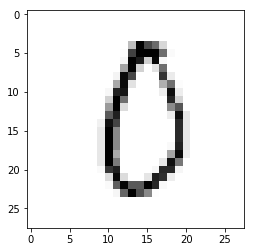

In [31]:
image_index = 69
print(y_train[image_index])
plt.imshow(x_train[image_index,0], cmap='Greys')

In [43]:
class MNIST_data(Dataset):
    
    def __init__(self, file_path, transform=transforms.Compose([transforms.ToPILImage(),\
                        transforms.ToTensor(),transforms.Normalize(mean=(0.5,), std=(0.5,))])):
        df = pd.read_csv(file_path)
        
        if len(df.columns) == n_pixels:
            #test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            #training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [38]:
class RandomRotation(object):
    """
    https://github.com/pytorch/vision/tree/master/torchvision/transforms
    Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        
        def rotate(img, angle, resample=False, expand=False, center=None):
            """Rotate the image by angle and then (optionally) translate it by (n_columns, n_rows)
            Args:
            img (PIL Image): PIL Image to be rotated.
            angle ({float, int}): In degrees degrees counter clockwise order.
            resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
            expand (bool, optional): Optional expansion flag.
            If true, expands the output image to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
            center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
            """
                
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)

In [39]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)

In [44]:
batch_size = 64

train_dataset = MNIST_data(train_path, transform= transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=20), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = MNIST_data(test_path)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

In [61]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

In [62]:
network = Net()
optimizer = optim.Adam(network.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

network

/Users/patrickcullinane/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p

In [67]:
def train(epoch):
    network.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data[0]))

In [68]:
def evaluate(data_loader):
    network.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        
        output = network(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data[0]
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [69]:
n_epochs = 1
for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number